In [1]:
import pandas as pd 
from matplotlib import pyplot as plt
import math as mt 
import numpy as np
from sympy import *
from sympy.abc import theta
from scipy.optimize import curve_fit

In [2]:
# Loading data from csv file | csv -> (comma-separated-values)
df = pd.read_csv('dados_gaia.csv', encoding='ISO-8859-1')

# Calculating distances and adding to dataFrame | Parallax is a difference in the apparent position of an object viewed along two different lines of sight
df['range'] = 1000/(df['parallax']) # The range unit is 'pc'

# visualizar a matriz de dados
print(df.head())

           ra       dec  parallax          l         b         pm       pmra  \
0  285.466579  5.683476  2.238047  39.176829  0.279242   6.329538   1.969018   
1  285.455926  5.698511  2.511152  39.185344  0.295548  11.044467   8.495857   
2  285.491975  5.703664  5.687639  39.206346  0.266016  78.955700  61.732914   
3  285.490436  5.722492  3.792153  39.222384  0.275997  65.405210   4.451024   
4  285.509115  5.758464  2.678990  39.262874  0.275941  19.226456   6.898079   

       pmdec       range  
0  -6.015482  446.818150  
1  -7.056959  398.223639  
2  49.224494  175.819871  
3 -65.253586  263.702411  
4 -17.946395  373.274972  


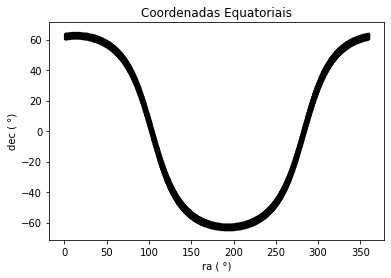

In [4]:
# Gráfico RA_DEC
plt.scatter(df['ra'], df['dec'], color='black', s=0.005)
plt.xlabel('ra ( °)')
plt.ylabel('dec ( °)')
plt.title('Coordenadas Equatoriais')
plt.savefig('coordenadas-equatoriais.jpg')
#plt.show()

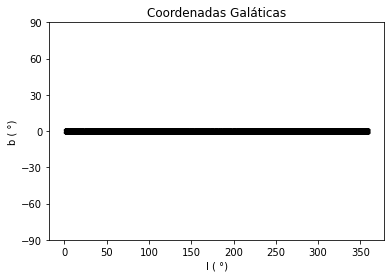

In [5]:
# Gráfico L_B
plt.scatter(df['l'], df['b'], color='black', s=0.005)
plt.xlabel('l ( °)')
plt.ylabel('b ( °)')
plt.title('Coordenadas Galáticas')
plt.yticks(np.arange(-90, 120, 30))
plt.savefig('coordenadas-galáticas.jpg')
#plt.show()

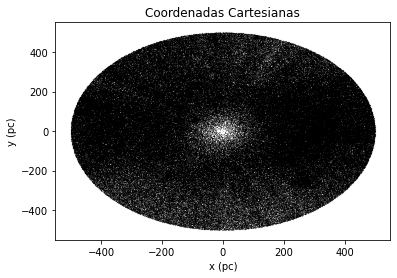

In [6]:
# Trasformação de coordenadas
# 'l' e 'b' são dados em graus 
x = df['range'] * np.cos(np.radians(df['b'])) * np.sin(np.radians(df['l']))
y = df['range'] * np.cos(np.radians(df['b'])) * np.cos(np.radians(df['l']))
z = df['range'] * np.sin(np.radians(df['b']))

# Gráfico xy
plt.scatter(x, y, color='black', s=0.005)
plt.xlabel('x (pc)')
plt.ylabel('y (pc)')
plt.title('Coordenadas Cartesianas')
plt.savefig('coordenadas-cartesianas-xy.jpg')
#plt.show()

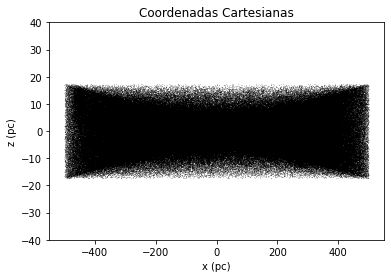

In [7]:
# Gráfico xz
plt.scatter(x, z, color='black', s=0.005)
plt.xlabel('x (pc)')
plt.ylabel('z (pc)')
plt.yticks(np.arange(-40, 50, 10))
plt.title('Coordenadas Cartesianas')
plt.savefig('coordenadas-cartesianas-xz.jpg')
#plt.show()

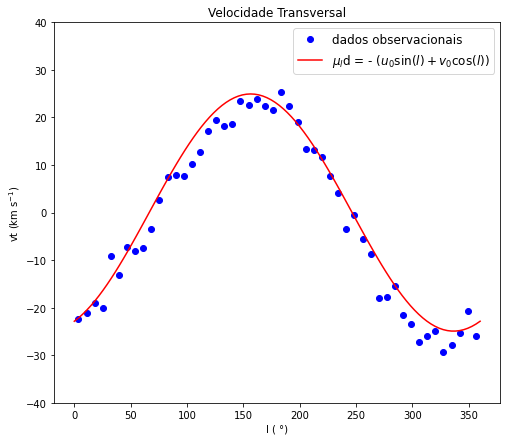

In [9]:
# We need to select a sample of star in the vicinity of the solar system | Then I will select the distant stars up to 100 pc from us
new_df = df.loc[df['range']<100]

# Resetting the indexes to stay organized
new_df = new_df.reset_index()

# We need to change the coordinate system of the proper motion which is in equatorial coordinates and we will mod to galactic coordinates.

# This transformation can be found in the article: https://arxiv.org/pdf/1306.2945.pdf
alpha_G = np.radians(192.85948)
delta_G = np.radians(27.12825)

# Calculating rotation matrix constants
c1 = np.sin(delta_G)*np.cos(np.radians(new_df['dec'])) - np.cos(delta_G)*np.sin(np.radians(new_df['dec']))*np.cos(np.radians(new_df['ra']) - alpha_G)
c2 = np.cos(delta_G)*np.sin(np.radians(new_df['ra']) - alpha_G)
cosb = np.sqrt(c1**2 + c2**2)

# Adjusting the coordinate system
pm_l_estrela = 1/cosb * (c1*new_df['pmra'] + c2*new_df['pmdec'])
pm_b = 1/cosb * (-c2*new_df['pmra'] + c1*new_df['pmdec'])

# Traverse speed with units set
vt = pm_l_estrela*new_df['range']*4.74047/(np.cos(np.radians(new_df['b']))*1000)

# There are a lot of stars so we need to take a sample and average on important variables to fit analytic function to data

# First and second step in galactic coordinates
step = 7.2
l1 = 0
l2 = step

# Declaring samples arrays
lsample = []
vtsample = []

l = np.array(new_df['l'])

while l2 <= 360:
    cond = np.argwhere( (l>l1) & (l<l2) ).flatten()
    
    lsample.append(np.mean((new_df['l'])[cond]))
    vtsample.append(np.mean(vt[cond]))
    
    # Evolution
    l1 = l2
    l2 = l2 + step

# Define function
def func(l, u0, v0):
    return -(u0*np.sin(np.radians(l)) + v0*np.cos(np.radians(l)))   

# Fit
params, cov = curve_fit(func, lsample, vtsample)

u0   = params[0]
v0   = params[1]

# Evaluate func using fitted parameters
xfit = np.linspace(0,360,100)
yfit = func(xfit, u0, v0)


#plot data and fit
fig, ax = plt.subplots(figsize = (8,7))

plt.plot(lsample, vtsample, 'o', label='dados observacionais', color='blue')
plt.plot(xfit, yfit, label='$\mu_l$d = - ($u_0 \sin(l) + v_0 \cos(l)$)', color='red')

plt.legend(fontsize=12)

plt.yticks(np.arange(-40, 50, 10))
plt.xlabel('l ( °)')
plt.ylabel('vt (km s$^{-1})$')
plt.title('Velocidade Transversal')
plt.savefig('transverse-speed.jpg')
#plt.show()

A = 15.806054
B = -13.055117


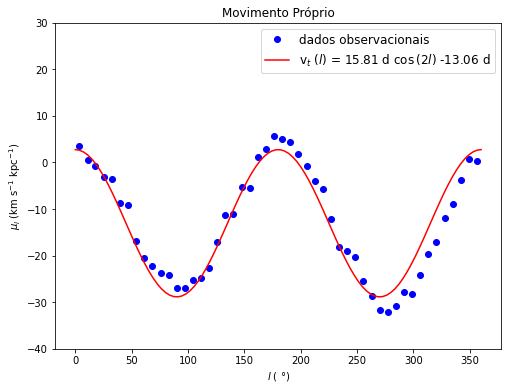

In [48]:
# Vou refazer os cálculos para todos os dados



# ascensão reta = alpha, declinação = delta
# Constantes definidas $Poleski$
alphaG = np.radians(192.85948)
deltaG = np.radians(27.12825)

# constantes da matriz de rotação
c1 = np.sin(deltaG)*np.cos(np.radians(df['dec'])) - np.cos(deltaG)*np.sin(np.radians(df['dec']))*np.cos(np.radians(df['ra']) - alphaG)
c2 = np.cos(deltaG)*np.sin(np.radians(df['ra']) - alphaG)
cosb = np.sqrt(c1**2 + c2**2)

# Tranformando o movimento próprio para coordenadas apropriadas "l"
mp_l_estrela = 1/cosb * (c1*df['pmra'] + c2*df['pmdec'])


# Cálculo do movimento próprio real, todas as unidades estão ajustadas
correcao = 1000*(u0*np.sin(np.radians(df['l'])) + v0*np.cos(np.radians(df['l'])))/df['range']
mpl = mp_l_estrela*4.74047/np.cos(np.radians(df['b'])) + correcao

# Para melhor visualização é apropriado fazer uma binagem, todas as variáveis usadas anteriormentes serão resetadas

# Passos
l1 = 0
l2 = 7.2

# Vetores a serem carregados
lsample = []
mplsample = []

# criação de um array, redundante?
l = np.array(df['l'])

while l2 <= 360:
    cond = np.argwhere( (l>l1) & (l<l2) ).flatten()
    
    lsample.append(np.mean(l[cond]))
    mplsample.append(np.mean(mpl[cond]))
    
    # Evolução
    l1 = l2
    l2 = l2 + 7.2


    
    
    
    
############## função que será fitada ################
def func(l, A, B):
    return A*np.cos(2*np.radians(l)) + B  

# fitar a curva
params, cov = curve_fit(func, lsample, mplsample)

A   = params[0]
B   = params[1]

print('A = %lf' % (A))
print('B = %lf' % (B))

# evaluate func using fitted parameters
xfit = np.linspace(0,360,100)
yfit = func(xfit, A, B)

#plot data and fit
fig, ax = plt.subplots(figsize=(8,6))



plt.plot(lsample, mplsample, 'o', label='dados observacionais', color='blue')
plt.plot(xfit, yfit, label=f'v$_t$ ($l$) = {np.around(A,2)} d $\cos$(2$l$) {np.around(B,2)} d', color='red')
plt.legend(fontsize=12)

plt.xlabel('$l$ ( °)')
plt.ylabel('$\mu_l$ (km s$^{-1}$ kpc$^{-1}$)')
plt.yticks(np.arange(-40, 40, 10))
plt.title('Movimento Próprio')
plt.savefig('proper-motion.jpg')
#plt.show()